# HAZMAP

Hazmap is a computer program for simulating sedimentation of volcanic particles from discrete point sources. It can provide both ground deposits as well as probabilities of being over a given loading threshold.

Given that the main input file is very extensive, and multiple files are neccesary, we advise that you either refer to [this](https://digital.csic.es/bitstream/10261/241364/2/Manual-hazmap-2.4.4.pdf) document, or use the `GENINP` utility for the creation of the main file, and then source the easier to create files such as the wind profile.

### Wind Input File

The wind profiles used by HAZMAP are defined in the file winds.dat. In this file an arbitrary number of wind profiles can be specified. We provide an example file for the user to edit as necessary. If HAZMAP is used in *deposit mode*, then only the first wind profile is read and used. In *probability mode* all the wind profiles are used for producing the probability map. The file winds.dat has the following format:

- The first record defines the number of z-levels where
the wind velocities are measured (NLEV).
- The following NLEV records specify the height of z-
levels (in meters).
- One or more groups of NLEV records six fields
(Year, Month, Day, Level, VX ; VY ). Only the
velocity components VX and VY are used by HAZMAP. The level number is also read by HAZMAP for
an internal consistency check.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import netCDF4 as nc
import os
import subprocess
import xarray as xr
import rioxarray as rxr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import Stamen
import utm

### Input File 

HAZMAP allows the user to provide their own input file, but we advise using this simplified path that creates the input for you.

Additionally, set `savefig` to False if you do not want to save the figure. Set `cleanup` to false if you want to keep all files.

In [2]:
generate_input = True
savefig = True
cleanup = False

### Below, enter 0/1 (no/yes unless otherwise specified) for the following options.

In [3]:
#Select 0/1 for deposit/probability
mode = 0

#Select 0/1 for uniform/from file
grid_type = 0

#Select settling velocity model (0/1)
settling_v = 1

#Toggle if settling velocity is a function of z (0/1)
sv_func_z = 1

#Toggle output of cell coordinates to grid.out file (0/1)
write_cell_coords = 0

#output particle spectra to file (0/1)
write_particle_spectra = 0

#Toggle output of settling velocity to vset.out (0/1)
write_settling = 0

### Below, please set grid specifications.

This include both spacing, as well as overall mass, its origin, and ditribution.

In [4]:
#set grid type format (irregular = 1, deposit/probability = 2, grd ascii file = 3, grd binary file = 4), 2 is default
form = 2

#input number of x and y cells for grid from file (two ints with space in between)
num_grid_cells = "200 200"

#input grid spacing for uniform grid( two ints or floats with space in between)
grid_spacing = "400 400"

#center coordinate in UTM (two ints with a space in between)
center_coord = "451469. 4518977"

#Total mass (scientific notation)
total_mass = "5.0E11"

#Select mass distribution model from file/Suzuki model (0/1)
mass_distrib = 1

#UTM coordiantes of grid
coord_vent = "451469. 4518977. 0.0"

### Below, please set values relating to the altitude and general diffusion structure of the particles.

In [5]:
#height of column, meters above sea level
column_height = 17000

#input number of vertical source points
vert_src_points = 36

#Input the two Suzuki coefficients for the model (two ints with a space in between)
suzuki_coeffs = "4. 1."

#Input diffusion coefficient
diffusion_coeff = 5000

#Input integer number of loading threshold values
num_loading_threshold = 10

#input num_loading_threshold amount of thresholds
thresholds = "100 200 300 400 500 600 700 800 900 1000"

### Particle Parameters

Please set the number of particle types, along with corresponding input lists of diameters, densities, shapes, and weight percentages.

In [6]:
#number of particle types 
num_particle_types = 10

diameters = ["15.62e-6","31.25e-6","62.50e-6","125.0e-6","250.0e-6","500.0e-6","1.000e-3","2.000e-3","4.000e-3","8.000e-3"]

densities = [2500,2500,2500,2500,2500, 1700,1700, 1400,1400,1400]

shapes = [1,1,1,1,1,1,1,1,1,1]

weight_percent = [7,10,12,21,17,10,9,8,5,1]

### Run The Model

All subsequent cells can be run without user interaction

The following three cells are involved with proper formatting of files. The next three run the model, format the output into a standardized format, and plot the isomass lines.

In [7]:
geninp = f'''{mode}
{grid_type}
{settling_v}
{sv_func_z}
{write_cell_coords}
{write_particle_spectra}
{write_settling}
{form}
{num_grid_cells}
{grid_spacing}
{center_coord}
{total_mass}              
{mass_distrib}
{coord_vent}
{column_height}
{vert_src_points}
{suzuki_coeffs}
{diffusion_coeff}
{num_loading_threshold}
{thresholds}
{num_particle_types}
'''

In [8]:
particles = ""
for i in range(10):
    particles += "%s  %d %d %.1f\n" % (diameters[i], densities[i], shapes[i], weight_percent[i])
combined = geninp+particles
gen = open("geninp.inp",'w')
gen.write(combined)
gen.close()

In [9]:
if generate_input:
    subprocess.run("./geninp geninp.inp",shell=True)

Sum of particles percentages = 100.000%
Sum of mass sources fractions=   1.0000    


In [10]:
subprocess.run("./hazmap",shell=True)
subprocess.run("./haz2nc hazmap.out",shell=True)

hazmap 2.4.4
 * Lower wind Z-level is not 0. (extrapolated).
Mode: Deposit
TOTAL MASS =  0.50000E+12
Deposit mass= 0.15854E+12 (approximate)
Wrote output file (ASCII): hazmap.out
 Min Load=   3.17789996E-28
 Max Load=   1037.00000    
 Using UTM coordinates


CompletedProcess(args='./haz2nc hazmap.out', returncode=0)

In [11]:
ds = xr.load_dataarray("hazmap.nc")
coords = coord_vent.split()[:-1]
coords = [int(coor[:-1]) for coor in coords]

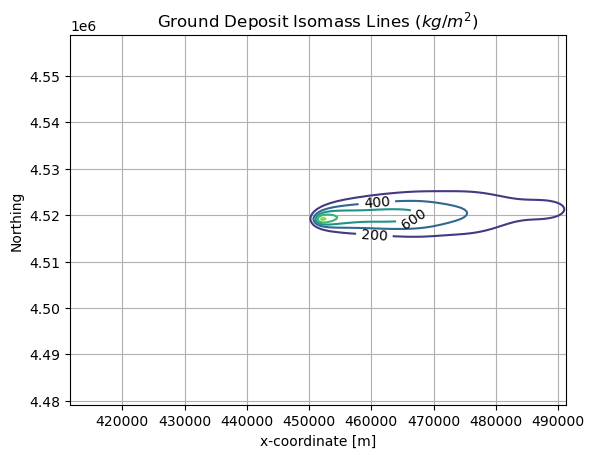

In [12]:
fig, ax = plt.subplots()
plotted = ds.plot.contour()
plotted.clabel(colors="black")
plt.ylabel("Northing")
plt.title(r'Ground Deposit Isomass Lines $(kg/m^2)$')
plt.grid()
if savefig:
    plt.savefig("hazmap.svg")

In [13]:
if cleanup:
    os.remove("geninp.inp")
    os.remove("hazmap.inp")
    os.remove("hazmap.out")